# MC dropout abstention (baseline mode)

Produce N forward passes and record variance and mean.

Train model that receives variance and mean of a particular diagnostic on a particular visit and models if that prediction is True positive or False positive.

baseline mode means:
1. I'm using validation set to train the LR on tp vs. fp. and test set to evaluate the model on an unseen data
2. I'm using a simple threshold of 0.5 on the logistic regressions.

In [57]:
df_metrics

,diag,precision,recall,f1,clf,type
0,diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
1,diag_1,0.852941,0.728033,0.785553,LogisticRegression(class_weight='balanced'),model
2,diag_2,0.833333,0.714286,0.769231,LogisticRegression(class_weight='balanced'),model
3,diag_3,0.925926,0.684932,0.787402,LogisticRegression(class_weight='balanced'),model
4,diag_4,0.928571,1.000000,0.962963,LogisticRegression(class_weight='balanced'),model
...,...,...,...,...,...,...
267,diag_267,0.870968,0.586957,0.701299,LogisticRegression(class_weight='balanced'),model
268,diag_268,1.000000,0.666667,0.800000,LogisticRegression(class_weight='balanced'),model
269,diag_269,NaN,NaN,NaN,DumbClassifier(),dumb
270,diag_270,NaN,NaN,NaN,DumbClassifier(),dumb


In [1]:
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

In [3]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(os.path.dirname(cwd)).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(os.path.dirname(cwd)) # parent directory
os.chdir(new_cwd)

In [45]:
import sys
import os
this_dir = ".."
if this_dir not in sys.path:
    sys.path.append(this_dir)

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model, outs2df_mc, compute_metrics

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid, ParameterSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice

from config import Settings; settings = Settings()

import wandb

In [8]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [9]:
dataset_id = 'diag_only'
grouping = 'ccs'
batch_size=64

In [10]:
dataset_folder = os.path.join(settings.data_base,settings.model_ready_dataset_folder,dataset_id)
print('dataset at',dataset_folder)

dataset = DiagnosesDataset(os.path.join(dataset_folder,'dataset.json'),grouping)

train_dataset = DiagnosesDataset(os.path.join(dataset_folder,'train_subset.json'),grouping)
val_dataset = DiagnosesDataset(os.path.join(dataset_folder,'val_subset.json'),grouping)
test_dataset = DiagnosesDataset(os.path.join(dataset_folder,'test_subset.json'),grouping)


len(train_dataset)
len(val_dataset)
len(test_dataset)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset))

dataset at data/model_ready_dataset/diag_only


5249

1125

1125

In [11]:
input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]
hidden_size = 100
num_layers = 1
n_labels = input_size
model_type = 'gru'

In [12]:
dropout = 0.2
dropouti = dropout
dropoutw = dropout
dropouto = dropout

In [13]:
model = VariationalRNN(input_size=input_size,
                       hidden_size=hidden_size,
                       n_labels=n_labels,
                       num_layers=num_layers,
                       rnn_type=model_type,
                       dropouti=dropouti,
                       dropoutw=dropoutw,
                       dropouto=dropouto
                      )

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
epochs = 10

In [15]:
losses = []
for epoch in range(epochs):
    eval_model(model,val_dataloader,dataset,['recall@30'])[1]['recall@30_adm']
    loss = train_one_epoch(model,train_dataloader,epoch,criterion,opt)
    losses.append(loss)
    print(f'epoch: {epoch+1} | loss: {loss}')

0.09338595837009094

epoch: 1 | loss: 0.1768575266721737


0.5978395954393771

epoch: 2 | loss: 0.12670961363487934


0.6468799973735518

epoch: 3 | loss: 0.12123737924070244


0.6683152002844288

epoch: 4 | loss: 0.11769239712192352


0.6644883834566765

epoch: 5 | loss: 0.114641822695014


0.6796602510058005

epoch: 6 | loss: 0.1127079840166023


0.692805877349853

epoch: 7 | loss: 0.11075322985290045


0.7030957856054423

epoch: 8 | loss: 0.10890622885830431


0.7053674280792359

epoch: 9 | loss: 0.10731690341090581


0.6965423997021247

epoch: 10 | loss: 0.10692487639116954


In [20]:
res,golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)
res.head(3)

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index n_pass                                                     
21     1         1       0.020531  0.216404  0.072091  0.162227  0.000443   
                 2       0.010297  0.102251  0.030303  0.036251  0.065843   
                 3       0.007895  0.386899  0.055907  0.090702  0.000578   

                           diag_5    diag_6    diag_7    diag_8    diag_9  \
pat_id adm_index n_pass                                                     
21     1         1       0.007322  0.018025  0.005737  0.001050  0.006624   
                 2       0.106968  0.005900  0.004008  0.002006  0.012314   
                 3       0.005508  0.004523  0.001558  0.000425  0.023492   

                         ...  diag_262  diag_263  diag_264  diag_265  \
pat_id adm_index n_pass  ...                                           
21     1         1       ...  0.000403  0.002913  0.000294  0.004530   
                 2       ...  0.000119  0.006748  0.000266  0.000573   
                 3       ...  0.000129  0.000715  0.000052  0.002578   

                         diag_266  diag_267  diag_268  diag_269  diag_270  \
pat_id adm_index n_pass                                                     
21     1         1       0.164567  0.163818  0.008326  0.001014  0.004598   
                 2       0.117630  0.033387  0.004778  0.003512  0.002958   
                 3       0.138509  0.070076  0.001603  0.001080  0.001821   

                         diag_271  
pat_id adm_index n_pass            
21     1         1       0.047660  
                 2       0.045178  
                 3       0.037675  

[3 rows x 272 columns]

In [21]:
stats_res = res.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_res.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
21     1          0.026593  0.000981  0.290014  0.031679  0.112635  0.006965   
23     1          0.002916  0.000004  0.110778  0.005403  0.071182  0.001464   
61     1          0.009471  0.000359  0.237054  0.012893  0.075650  0.001468   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
21     1          0.162575  0.019077  0.010351  0.000474  ...  0.102963   
23     1          0.044758  0.001194  0.003807  0.000052  ...  0.066401   
61     1          0.153235  0.003308  0.069210  0.009354  ...  0.141195   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
21     1          0.002855  0.003928  0.000007  0.002545  5.614503e-06   
23     1          0.000798  0.003681  0.000012  0.000324  1.046972e-07   
61     1          0.003706  0.022280  0.000570  0.001461  1.329885e-06   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
21     1          0.003601  0.000006  0.038908  0.000541  
23     1          0.013286  0.000110  0.029615  0.000183  
61     1          0.014196  0.000093  0.035902  0.000523  

[3 rows x 544 columns]

In [24]:
k = 30
topk_outputs = stats_res.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_res.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_res.index)
topk_predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
61,1,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [25]:
TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_res.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
variances.head(3)

means = stats_res.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(3)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.000981,0.031679,0.006965,0.019077,0.000474,0.035662,0.000032,0.000048,0.000004,0.000647,...,1.165848e-07,7.692295e-05,1.281590e-07,0.000062,0.002958,0.002855,0.000007,5.614503e-06,0.000006,0.000541
23,1,0.000004,0.005403,0.001464,0.001194,0.000052,0.000074,0.000356,0.000004,0.000001,0.000135,...,3.391438e-07,9.096460e-07,1.931278e-07,0.000003,0.005728,0.000798,0.000012,1.046972e-07,0.000110,0.000183
61,1,0.000359,0.012893,0.001468,0.003308,0.009354,0.000195,0.004447,0.000068,0.000016,0.000753,...,2.487943e-07,2.755981e-05,2.173827e-07,0.000008,0.002241,0.003706,0.000570,1.329885e-06,0.000093,0.000523


,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.026593,0.290014,0.112635,0.162575,0.010351,0.096086,0.007492,0.006641,0.001516,0.027213,...,0.000472,0.006974,0.000288,0.008621,0.123671,0.102963,0.003928,0.002545,0.003601,0.038908
23,1,0.002916,0.110778,0.071182,0.044758,0.003807,0.004816,0.020090,0.001511,0.001375,0.017796,...,0.000455,0.001525,0.000445,0.001741,0.158420,0.066401,0.003681,0.000324,0.013286,0.029615
61,1,0.009471,0.237054,0.075650,0.153235,0.069210,0.013711,0.099760,0.008976,0.003178,0.038948,...,0.000680,0.006048,0.000449,0.003012,0.123703,0.141195,0.022280,0.001461,0.014196,0.035902


In [69]:
tp_means.mean(0).mean()

fp_means.mean(0).mean()

0.3667918

0.2229018

In [68]:
fp_means.mean(0).mean()

0.2229018

<AxesSubplot:>

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'distribution in mean forward_pass of diag 88')

<AxesSubplot:>

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

Text(0.5, 1.0, 'distribution in variance of the forward_pass of diag 88')

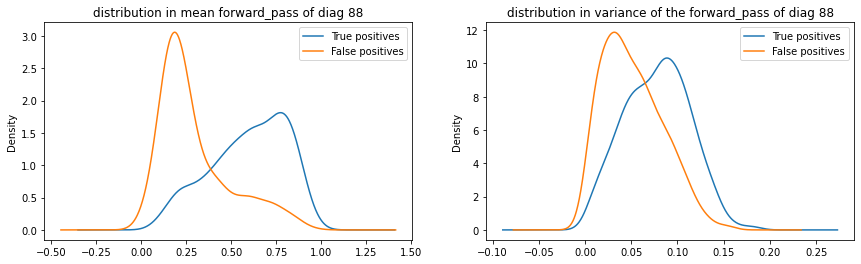

Text(0.5, 0, 'mean of forward passes')

Text(0, 0.5, 'var of forward passes')

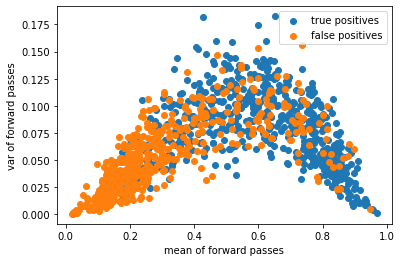

In [86]:
#parameter
diag = 88


diag_col = f'diag_{diag}'
plt.subplot(1,2,1)
tp_means[diag_col].plot.kde(label='True positives');
fp_means[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in mean forward_pass of diag {diag}');
plt.legend();
#plt.show();
plt.subplots_adjust(right=2) 
plt.subplot(1,2,2)
tp_variances[diag_col].plot.kde(label='True positives');
fp_variances[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in variance of the forward_pass of diag {diag}');
plt.legend();
plt.show()

tp = pd.concat([tp_means[diag_col],tp_variances[diag_col]],axis=1)
tp.columns = ['mean','var']

fp = pd.concat([fp_means[diag_col],fp_variances[diag_col]],axis=1)
fp.columns = ['mean','var']

plt.scatter(tp['mean'],tp['var'],label='true positives')
plt.scatter(fp['mean'],fp['var'], label = 'false positives')
plt.xlabel('mean of forward passes')
plt.ylabel('var of forward passes')
plt.legend()

In [ ]:
#parameter
diag = 188


diag_col = f'diag_{diag}'
plt.subplot(1,2,1)
tp_means[diag_col].plot.kde(label='True positives');
fp_means[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in mean forward_pass of diag {diag}');
plt.legend();
#plt.show();
plt.subplots_adjust(right=2) 
plt.subplot(1,2,2)
tp_variances[diag_col].plot.kde(label='True positives');
fp_variances[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in variance of the forward_pass of diag {diag}');
plt.legend();

# Model whether a prediction will be FP or TP

# Dumb classifier

since some diagnostics won't have enough data to train a model on, we will use 'dumb' classifiers to keep the pipeline consistent. These classifiers will always predict the positive class

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class DumbClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass
    def fit(self, X, y):
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        #self.classes_ = unique_labels(y)
        #self.X_ = X
        #self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
         # Check if fit has been called
        #check_is_fitted(self)
        
        # Input validation
        #X = check_array(X)
        y = np.zeros(shape=(X.shape[0],),dtype=int)
        return y

# test this out
from sklearn.pipeline import make_pipeline

X = np.ones(shape=(5,5))
y = np.random.randint(0,2,size=(5,))

pipe = make_pipeline(DumbClassifier())

pipe.fit(X,y)
pipe.predict(X) # Expecting all ones

Pipeline(steps=[('dumbclassifier', DumbClassifier())])

array([0, 0, 0, 0, 0])

# Build dataset

we shall build the dataset using the validation set (from the original train-val-test split).

We need:
1. obtain predictions on the validation set
2. gather all TP and FP examples
3. construct N tabular datasets (one for each diagnostic)
4. split each into train-test
5. train and test classifier
    1. metric should be precision, recall and f1

In [30]:
outs, golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)

In [31]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])

k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)
#topk_predictions.head(1)

TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(1)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(1)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.012332,0.285125,0.172085,0.139681,0.005358,0.107338,0.008251,0.004615,0.001259,0.06264,...,0.000503,0.009851,0.000201,0.014711,0.114903,0.08989,0.005902,0.00301,0.003631,0.035527


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression

In [51]:
# need two conditions to decide wether to use the dumb classifier or not
# 1) threhsold on the number of examples
# 2) and there must be examples of both classes

df_metrics = pd.DataFrame(columns=['diag','precision','recall','f1','clf','type'])

signal = False
clf_party = {}
threshold = 20
for diag in outs.columns:
    
    n_TP = (TP[diag] == True).sum()
    n_FP = (FP[diag] == True).sum()
    
    total_n = n_TP + n_FP
    
    if total_n < threshold or n_TP < 5 or n_FP < 5:
        #use dumb classifier
        clf = DumbClassifier()
        df_metrics = df_metrics.append({'diag':diag,'precision':np.nan,'recall':np.nan,'f1':np.nan,'clf':clf,'type':'dumb'},ignore_index=True)
    else:
        #use logistic regression
        
        ## create dataset
        mean_tp = means[diag][TP[diag]].to_frame('mean')
        mean_fp = means[diag][FP[diag]].to_frame('mean')
        
        var_tp = variances[diag][TP[diag]].to_frame('var')
        var_fp = variances[diag][FP[diag]].to_frame('var')
        
        df_tp = pd.concat([mean_tp,var_tp],axis=1).assign(label=0).reset_index(drop=True)
        df_fp = pd.concat([mean_fp,var_fp],axis=1).assign(label=1).reset_index(drop=True)
        
        df = pd.concat([df_tp,df_fp],ignore_index=True).sample(frac=1.0)
        
        if signal == False:
            print('TP/FP dataset for diagnostic ',diag)
            display(df)
            signal = True
        
        ## split into train-test
        
        X_train,X_test,y_train,y_test = train_test_split(df[['mean','var']],df['label'],stratify=df['label'])
        
        ## train
        clf = LogisticRegression(class_weight="balanced");
        clf.fit(X_train,y_train);
        
        ## evaluate
        preds = clf.predict(X_test);
        
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        f1 = f1_score(y_test,preds)
        
        df_metrics = df_metrics.append({'diag':diag,'precision':precision,'recall':recall,'f1':f1,'clf':clf,'type':'model'},ignore_index=True)
    
    clf_party[diag] = clf
    

TP/FP dataset for diagnostic  diag_1


,mean,var,label
165,0.253695,0.030461,0
232,0.187910,0.009656,0
1179,0.108154,0.001287,1
871,0.222993,0.012765,1
1195,0.208780,0.026406,1
...,...,...,...
48,0.101840,0.002284,0
602,0.199333,0.014095,1
412,0.357262,0.039538,1
393,0.118285,0.004159,1


LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

In [54]:
df_metrics

,diag,precision,recall,f1,clf,type
0,diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
1,diag_1,0.852941,0.728033,0.785553,LogisticRegression(class_weight='balanced'),model
2,diag_2,0.833333,0.714286,0.769231,LogisticRegression(class_weight='balanced'),model
3,diag_3,0.925926,0.684932,0.787402,LogisticRegression(class_weight='balanced'),model
4,diag_4,0.928571,1.000000,0.962963,LogisticRegression(class_weight='balanced'),model
...,...,...,...,...,...,...
267,diag_267,0.870968,0.586957,0.701299,LogisticRegression(class_weight='balanced'),model
268,diag_268,1.000000,0.666667,0.800000,LogisticRegression(class_weight='balanced'),model
269,diag_269,NaN,NaN,NaN,DumbClassifier(),dumb
270,diag_270,NaN,NaN,NaN,DumbClassifier(),dumb


In [36]:
df_metrics.f1.describe()

count    130.000000
mean       0.778522
std        0.116201
min        0.222222
25%        0.726173
50%        0.783482
75%        0.857143
max        1.000000
Name: f1, dtype: float64

In [37]:
df_metrics = df_metrics.set_index('diag')
df_metrics.head(2)

,precision,recall,f1,clf,type
diag,,,,,
diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
diag_1,0.825472,0.732218,0.776053,LogisticRegression(class_weight='balanced'),model


## Classifiers are trained. Now we need to apply them

In [40]:
# notice we use the test set now
outs, golden = outs2df_mc(model,test_dataloader,dataset,return_golden=True)

In [41]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_outs.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
111    1          0.004701  0.000019  0.116785  0.005887  0.065542  0.001256   
145    1          0.001755  0.000003  0.424322  0.024145  0.152189  0.007601   
199    1          0.017339  0.000251  0.114845  0.000946  0.053656  0.000374   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
111    1          0.079300  0.004014  0.004696  0.000131  ...  0.074276   
145    1          0.091257  0.003928  0.003754  0.000069  ...  0.084654   
199    1          0.056983  0.000498  0.004713  0.000039  ...  0.095553   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
111    1          0.001889  0.007996  0.000072  0.000820  8.537181e-07   
145    1          0.001018  0.009084  0.000135  0.001416  3.885988e-06   
199    1          0.001233  0.003930  0.000009  0.001536  4.073438e-06   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
111    1          0.007856  0.000032  0.032915  0.000292  
145    1          0.010190  0.000054  0.039373  0.000964  
199    1          0.005488  0.000016  0.017995  0.000222  

[3 rows x 544 columns]

In [42]:
k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)

In [43]:
def abstain(row,df_metrics,stats_outs):
    """
    Receives a row which contains the predictions of all diagnoses (0 or 1) for a given admission.
    Also receives df_metrics, which contains the LRs trained on each diagnostic (that predicts if TP or FP)
    And stats_outs contains the means and variances of the forward passes.
    
    this function will turn some predictions from 1 to 0 if the LR model predicts it will be a FP.
    """
    new_row = row.copy()
    admission_forward_stats = stats_outs.loc[row.name,:]
    for index,elem in row.iteritems():
        if elem == 1:
            datapoint = admission_forward_stats[index].to_numpy()
            clf = df_metrics.loc[index,'clf']
            pred = clf.predict(datapoint.reshape((-1,2)))
            
            if pred == 1: #abstain
                new_row[index] = 0
    return new_row

and abstain from topk now

In [46]:
# metrics of topk
metrics_normal = compute_metrics(topk_outputs_all_cols.fillna(0),topk_predictions,golden,['precision@30','recall@30','f1@30'])

# metrics of topk and abstention afterwards

top_k_predictions_abstained = topk_predictions.apply(lambda row: abstain(row,df_metrics,stats_outs),axis=1)
topk_outputs_all_cols_after_abstention = topk_outputs_all_cols.fillna(0).mask(top_k_predictions_abstained == 0,0)
metrics_w_abstention = compute_metrics(topk_outputs_all_cols_after_abstention,top_k_predictions_abstained,golden,['precision@30','recall@30','f1@30'])

In [47]:
metrics_normal.name = 'initial top 30'
metrics_w_abstention.name = 'top 30 + abstention through MC dropout'
pd.concat([metrics_normal,metrics_w_abstention],axis=1).iloc[3:]

,initial top 30,top 30 + abstention through MC dropout
metrics,,
precision@30_adm,0.275204,0.466208
recall@30_adm,0.699512,0.453028
f1@30_adm,0.378593,0.430229


-----

# Adding Kurtosis to the mix

In [112]:
outs, golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)

In [129]:
kurtosis = outs.groupby(['pat_id','adm_index']).apply(pd.DataFrame.kurt)
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])

for diag in kurtosis:
    stats_outs[diag,'kurt'] = kurtosis[diag]
stats_outs.head(3)

/var/folders/__/lcwlgwm95q9_vf5ypxxn3d7c0000gn/T/ipykernel_39848/668331799.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_outs[diag,'kurt'] = kurtosis[diag]


In [131]:
k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)
#topk_predictions.head(1)

TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(1)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
#means.head(1)

kurts = stats_outs.loc[idx[:,:],idx[:,'kurt']]
kurts.columns = kurts.columns.get_level_values(0)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

tp_kurts = kurts.where(TP,np.nan)
fp_kurts = kurts.where(FP,np.nan)

In [132]:
# need two conditions to decide wether to use the dumb classifier or not
# 1) threhsold on the number of examples
# 2) and there must be examples of both classes

df_metrics = pd.DataFrame(columns=['diag','precision','recall','f1','clf','type'])

signal = False
clf_party = {}
threshold = 20
for diag in outs.columns:
    
    # number of
    n_TP = (TP[diag] == True).sum()
    n_FP = (FP[diag] == True).sum()
    
    total_n = n_TP + n_FP
    
    if total_n < threshold or n_TP < 5 or n_FP < 5:
        #use dumb classifier
        clf = DumbClassifier()
        df_metrics = df_metrics.append({'diag':diag,'precision':np.nan,'recall':np.nan,'f1':np.nan,'clf':clf,'type':'dumb'},ignore_index=True)
    else:
        #use logistic regression
        
        ## create dataset
        mean_tp = means[diag][TP[diag]].to_frame('mean')
        mean_fp = means[diag][FP[diag]].to_frame('mean')
        
        var_tp = variances[diag][TP[diag]].to_frame('var')
        var_fp = variances[diag][FP[diag]].to_frame('var')
        
        kurt_tp = kurts[diag][TP[diag]].to_frame('kurt')
        kurt_fp = kurts[diag][FP[diag]].to_frame('kurt')
        
        df_tp = pd.concat([mean_tp,var_tp,kurt_tp],axis=1).assign(label=0).reset_index(drop=True)
        df_fp = pd.concat([mean_fp,var_fp,kurt_fp],axis=1).assign(label=1).reset_index(drop=True)
        
        df = pd.concat([df_tp,df_fp],ignore_index=True).sample(frac=1.0)
        
        if signal == False:
            print('TP/FP dataset for diagnostic ',diag)
            display(df)
            signal = True
        
        ## split into train-test
        
        X_train,X_test,y_train,y_test = train_test_split(df[['mean','var','kurt']],df['label'],stratify=df['label'])
        
        ## train
        clf = LogisticRegression(class_weight="balanced");
        clf.fit(X_train,y_train);
        
        ## evaluate
        preds = clf.predict(X_test);
        
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        f1 = f1_score(y_test,preds)
        
        df_metrics = df_metrics.append({'diag':diag,'precision':precision,'recall':recall,'f1':f1,'clf':clf,'type':'model'},ignore_index=True)
    
    clf_party[diag] = clf
    

TP/FP dataset for diagnostic  diag_1


,mean,var,kurt,label
793,0.209790,0.021233,1.430365,1
294,0.205194,0.027706,0.607582,0
731,0.396471,0.041492,-0.694213,1
110,0.296728,0.037543,-0.544347,0
1015,0.183827,0.007815,-0.386627,1
...,...,...,...,...
243,0.384062,0.018651,-1.878165,0
535,0.140794,0.007652,1.799939,1
832,0.136187,0.002181,-1.162193,1
358,0.210191,0.033971,1.715045,1


LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

## Classifiers are trained. Now we need to apply them

In [133]:
# notice we use the test set now
outs, golden = outs2df_mc(model,test_dataloader,dataset,return_golden=True)
kurtosis = outs.groupby(['pat_id','adm_index']).apply(pd.DataFrame.kurt)
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])
for diag in kurtosis:
    stats_outs[diag,'kurt'] = kurtosis[diag]

/var/folders/__/lcwlgwm95q9_vf5ypxxn3d7c0000gn/T/ipykernel_39848/1836995234.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  stats_outs[diag,'kurt'] = kurtosis[diag]


In [134]:
k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)

In [143]:
df_metrics = df_metrics.set_index('diag')

In [145]:
def abstainV2(row,df_metrics,stats_outs):
    """
    Receives a row which contains the predictions of all diagnoses (0 or 1) for a given admission.
    Also receives df_metrics, which contains the LRs trained on each diagnostic (that predicts if TP or FP)
    And stats_outs contains the means and variances of the forward passes.
    
    this function will turn some predictions from 1 to 0 if the LR model predicts it will be a FP.
    """
    new_row = row.copy()
    admission_forward_stats = stats_outs.loc[row.name,:]
    for index,elem in row.iteritems():
        if elem == 1:
            datapoint = admission_forward_stats[index].to_numpy()
            clf = df_metrics.loc[index,'clf']
            pred = clf.predict(datapoint.reshape((-1,3)))
            
            if pred == 1: #abstain
                new_row[index] = 0
    return new_row

In [146]:
# metrics of topk
metrics_normal = compute_metrics(topk_outputs_all_cols.fillna(0),topk_predictions,golden,['precision@30','recall@30','f1@30'])

# metrics of topk and abstention afterwards

top_k_predictions_abstained = topk_predictions.apply(lambda row: abstainV2(row,df_metrics,stats_outs),axis=1)
topk_outputs_all_cols_after_abstention = topk_outputs_all_cols.fillna(0).mask(top_k_predictions_abstained == 0,0)
metrics_w_abstention = compute_metrics(topk_outputs_all_cols_after_abstention,top_k_predictions_abstained,golden,['precision@30','recall@30','f1@30'])

In [147]:
metrics_normal.name = 'initial top 30'
metrics_w_abstention.name = 'top 30 + abstention through MC dropout&kurtosis'
pd.concat([metrics_normal,metrics_w_abstention],axis=1).iloc[3:]

,initial top 30,top 30 + abstention through MC dropout&kurtosis
metrics,,
precision@30_adm,0.275612,0.439594
recall@30_adm,0.701418,0.456042
f1@30_adm,0.379319,0.423056
